# Lab : Stochastic Gradient Descent

The goal of this lab is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

We begin with the standard imports:

In [1]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sys
import time
import math

We are going to use the W8A dataset, a tidy and binarized version of https://archive.ics.uci.edu/ml/datasets/adult (check it out for more details). 
In this dataset we have census data to predict if the income of an adult exceeds $50K/yr (1 or -1).  

In [2]:
w8a_train = pd.read_csv("w8a.csv", sep=";", header=None)
w8a_train_x = w8a_train.iloc[:, :-1]
w8a_train_y = w8a_train.iloc[:, -1]

w8a_test  = pd.read_csv("w8a_t.csv", sep=";", header = None)
w8a_test_x = w8a_test.iloc[:, :-1]
w8a_test_y = w8a_test.iloc[:, -1]

##### Train set shape

In [3]:
print("Train data set shape: ", w8a_train.shape)
w8a_train.head(2)

Train data set shape:  (49749, 301)


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


In [4]:
labels1=(w8a_train_y==1).values.sum()
labels_1=(w8a_train_y==-1).values.sum()
n=w8a_train_y.shape[0]
print ("Number of label 1 in train set : {} - ({}%)".format(labels1,round(labels1*100/n,2)))
print ("Number of label -1 in train set : {} - ({}%)".format(labels_1,round(labels_1*100/n,2)))

Number of label 1 in train set : 1479 - (2.97%)
Number of label -1 in train set : 48270 - (97.03%)


##### Test set shape

In [5]:
print("Test dataset shape: ", w8a_test.shape)
w8a_test.head(2)

Test dataset shape:  (14951, 301)


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


In [6]:
labels1=(w8a_test_y==1).values.sum()
labels_1=(w8a_test_y==-1).values.sum()
n=w8a_test_y.shape[0]
print ("Number of label 1 in test set : {} - ({}%)".format(labels1,round(labels1*100/n,2)))
print ("Number of label -1 in test set : {} - ({}%)".format(labels_1,round(labels_1*100/n,2)))

Number of label 1 in test set : 454 - (3.04%)
Number of label -1 in test set : 14497 - (96.96%)


## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [7]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=1.0)
model.fit(w8a_train_x, w8a_train_y)
y_pred = model.predict(w8a_test_x)

/Users/mehdiboubnan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


and we compute the accuracy score to evaluate the model performance:

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(w8a_test_y, y_pred)

0.9856865761487525

finally we plot the roc curve:

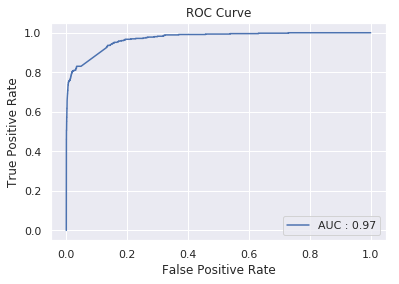

In [9]:
y_pred_proba_SK = model.predict_proba(w8a_test_x)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(w8a_test_y, y_pred_proba_SK, pos_label=1)
plt.plot(fpr,tpr,label='AUC : {}'.format(round(metrics.auc(fpr, tpr),2)))
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent. 

- Fill in the classes

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [10]:
class StochasticGradientDescentOptimizer():
    """ Class for optimization by gradient descent.
    
    Attributes:
    -----------
    f: function
        the function to optimize 
    fprime: function
        the matrix L = -Diag(y)*X to compute the function's gradient
    start: np.array
        the starting point, at which we begin our search
    lr: float
        the learning rate
    gamma_lr: float
        the decay for the learning rate (lr*n^(-gamma))
    bsize: integer
        size of the mini-batch
    acceleration: string
        name of the acceeleration strategy
    alpha: float
        regularisation coefficient
    theta: float
        momentum acceleration coefficient
    beta_history: list of np.array
        the list of all points where f has been evaluated
    f_history: list of np.array
        the list of all evaluated f
    """
    
    def __init__(self, f, fprime, start, bsize, alpha, gamma_lr=0.5, theta=0.8, lr=1e-1, acceleration="none"):
        """     
        Parameters:
        -----------
        f: function
            the function to optimize 
        fprime: function
            the matrix L = -Diag(y)*X to compute the function's gradient
        start: np.array
            the starting point, at which we begin our search
        lr: float
            the learning rate
        gamma_lr: float
            the decay for the learning rate (lr*n^(-gamma))
        bsize: integer
            size of the mini-batch
        acceleration: string
            name of the acceeleration strategy
        alpha: float
            regularisation coefficient
        theta: float
            momentum acceleration coefficient
        """
        # Store the parameters as attributes
        self.f      = f
        self.fprime = fprime
        self.beta   = start
        self.lr     = lr
        self.gamma_ = gamma_lr
        self.bsize  = bsize
        self.alpha_ = alpha
        self.theta  = theta
        self.acceleration  = acceleration
                
        # Save history as attributes
        self.beta_history = [start]
        self.f_history = [f(self.fprime(),start)]           
        
    def optimize(self, max_iter=100):
        """Use the stochastic gradient descent optimiser to optimise f.        
        Parameters:
        -----------
        max_iter: int
            Maximum number of iterations.        
        """
        # TODO        

        def fbis_prim(x):
            return np.exp(x)/(1+np.exp(x))
        
        def gradient(L,alpha,beta):
            current_bsize=L.shape[0]
            return np.dot(L.T,fbis_prim(np.dot(L,beta)))/current_bsize + alpha*beta

        L=self.fprime()
        n=L.shape[0]
        
        gradient_history=[]
        
        # Creating batches
        batches=[]
        bnum=math.ceil(n/self.bsize)
        indexes=np.arange(n)
        np.random.RandomState(42).shuffle(indexes)
        batches+=np.array_split(indexes[:n-n%self.bsize],n//self.bsize)
        if n%self.bsize!=0: batches+=[indexes[n-n%self.bsize:]] 
        
        print("Acceleration chosen :",self.acceleration)
        print("\t","{} iterations for {} batches".format(max_iter,bnum))
        
        # Creating the vector to average for SAG and SAGA accelerations
        if self.acceleration=='SAG' or self.acceleration=='SAGA':
            yit=np.vstack([gradient(L[[i]],self.alpha_,self.beta) for i in range(n)])
            
        for i in range(max_iter):
            # Updating the learning rate with the decay
            lr_t=self.lr/((i+1)**self.gamma_)
            
            if self.acceleration=="none":
                gradient_history+=[gradient(L[batches[i%bnum]],self.alpha_,self.beta)]
                self.beta=self.beta-lr_t*gradient_history[-1]

            if self.acceleration=="momentum":
                gradient_history+=[gradient(L[batches[i%bnum]],self.alpha_,self.beta)]
                if i==0:
                    self.beta=self.beta-lr_t*gradient_history[-1]
                else:
                    self.beta=self.beta -lr_t*gradient_history[-1] + self.theta*(self.beta_history[-1]-self.beta_history[-2])

            if self.acceleration=="AG":
                gradient_history+=[gradient(L[batches[i%bnum]],self.alpha_,self.beta)]
                self.beta=self.beta_history[-1]-lr_t*np.mean(gradient_history)

            if self.acceleration=="SAG":                
                it=np.random.randint(0,bnum)
                if i==0:
                    self.beta=self.beta-lr_t*np.mean(yit,axis=0)
                else:
                    yit[it]=gradient(L[batches[it]],self.alpha_,self.beta)
                    self.beta=self.beta-lr_t*np.mean(yit,axis=0)
            
            if self.acceleration=="SAGA":                
                it=np.random.randint(0,bnum)
                if i==0:
                    self.beta=self.beta-lr_t*np.mean(yit,axis=0)
                else:
                    prim_it_np1=gradient(L[batches[it]],self.alpha_,self.beta_history[-1])
                    self.beta=self.beta-lr_t*(prim_it_np1-yit[it]+np.mean(np.delete(yit, it, 0),axis=0))
                    yit[it]=prim_it_np1

            if self.acceleration=="ADAGRAD":
                prim_iter=gradient(L[batches[i%bnum]],self.alpha_,self.beta_history[-1])
                gradient_history+=[prim_iter**2]
                self.beta=self.beta-lr_t/np.sqrt(np.sum(gradient_history,axis=0)+1e-8)*prim_iter
            
            # Saving beta and loss history
            self.beta_history+=[self.beta]
            self.f_history+=[self.f(L,self.beta)]
            
    
    def plot_f_values(self):
        """Plot the historical f values once optimization is complete.          
        """
        # TODO
        plt.plot(range(len(self.f_history)),self.f_history,label=self.acceleration)
        plt.title("Evolution of the cost function")
        plt.legend()
            
    def print_result(self):
        """ Print out result once optimization is complete.        
        """
        sys.stdout.write("\t === Result ===\n")
        #sys.stdout.write("Beta: " + str(self.beta) +'\n')
        sys.stdout.write("\t Final Loss : Loss(beta) = " + str(round(self.f(self.fprime(),self.beta),4)) + '\n' + '\n')

In [11]:
class LogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    lr: float
        the learning rate
    gamma_lr: float
        the decay for the learning rate (lr*n^(-gamma))
    bsize: integer
        size of the mini-batch
    acceleration: string
        name of the acceeleration strategy
    alpha: float
        regularization parameter
    theta: float
        momentum acceleration coefficient
    iters: int
        number of iterations for the optimization
    plot: boolean
        boolean for ploting the loss evolution through optimization
    """
    
    def __init__(self, alpha, bsize, lr=1e-1, gamma_lr=0.5, theta=0.1, iters=500, acceleration="none", plot=True):
        self.coef_  = None
        self.f_history = None
        self.plot=plot
        self.alpha_ = alpha
        self.theta=theta
        self.lr     = lr
        self.gamma_ = gamma_lr
        self.bsize  = bsize
        self.iters = iters
        self.acceleration  = acceleration
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # TODO
        
        X_aug=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        y=y.reshape(-1,1)
        
        def f_lr(L,beta):            
            """ 
            Returns the logistic loss.        
            """
            return np.mean(np.log(1+np.exp(np.dot(L,beta))))+0.5*self.alpha_*np.sum(beta*beta)

        
        def fprime_lr():   
            """ Returns the L matrix to easily compute the f_ls and gradient of f_ls.
            """            
            return -y*X_aug
            
        
        beta_start=np.random.RandomState(42).normal(0,0.01,X_aug.shape[1])
        STGD=StochasticGradientDescentOptimizer(f=f_lr, fprime=fprime_lr, start=beta_start, bsize=self.bsize, alpha=self.alpha_, lr=self.lr, gamma_lr=self.gamma_, theta=self.theta, acceleration=self.acceleration)
        STGD.optimize(self.iters)
        if self.plot:
            STGD.plot_f_values()
        STGD.print_result()        
        self.coef_=STGD.beta
        self.f_history=STGD.f_history

    def plot_f_values(self):
        """Plot the historical f values once optimization is complete.          
        """
        plt.plot(range(len(self.f_history)),self.f_history,label=self.acceleration)
        plt.title("Evolution of the cost function")
        plt.legend()   
        
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (1 or -1)
        """
        # TODO
        
        X_aug=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)    
        
        return np.where((1/(1+np.exp(-np.dot(X_aug,self.coef_))))>0.5,1,-1)
    
    def predict_proba(self, X):
        """ Make probability predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (Probabilities)
        """
        # TODO
        
        X_aug=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    
        return 1/(1+np.exp(-np.dot(X_aug,self.coef_)))

# Application

### Defining some useful functions

In [12]:
def show_results(y_pred_labels,y_test,acceleration):
    labels1=(y_pred_labels==1).sum()
    labels_1=(y_pred_labels==-1).sum()
    n=y_pred_labels.shape[0]

    print("===","Acceleration chosen :",acceleration,"===")
    print ("Number of label 1 predictions : {} - ({}%)".format(labels1,round(labels1*100/n,2)))
    print ("Number of label -1 predictions : {} - ({}%)".format(labels_1,round(labels_1*100/n,2)))
    print("\t","Accuracy : {}".format(accuracy_score(y_test, y_pred_labels)),"\n")
    
def plot_roc(y_pred_proba,y_test,acceleration):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba, pos_label=1)
    plt.plot(fpr,tpr,label='AUC ('+acceleration+') : {}'.format(round(metrics.auc(fpr, tpr),2)))
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

### Setting Parameters

In [13]:
X=w8a_train_x.values
y=w8a_train_y.values
y_test = w8a_test_y.values

alpha=0
bsize=1
lr=1e-1
gamma_lr=0.5
theta=0.8
iters=500

## Evolution of the cost function for different learning rates

Learning rate chosen : 0.2
Acceleration chosen : none
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.1022

Learning rate chosen : 0.1
Acceleration chosen : none
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.1099

Learning rate chosen : 0.05
Acceleration chosen : none
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.1212

Learning rate chosen : 0.025
Acceleration chosen : none
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.1399

Learning rate chosen : 0.01
Acceleration chosen : none
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.1945



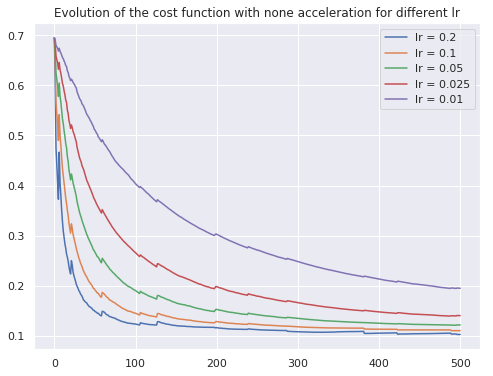

In [14]:
plt.figure(figsize=(8,6))
for lr in [0.2,0.1,0.05,0.025,0.01]:
    print("Learning rate chosen :",lr)
    clf_none=LogisticRegression(alpha=alpha, bsize=bsize, lr=lr, gamma_lr=0, iters=iters, acceleration="none", plot=False)
    clf_none.fit(X,y)
    
    plt.plot(clf_none.f_history,label="lr = {}".format(lr))
    plt.title("Evolution of the cost function with none acceleration for different lr")
    plt.legend()

## Evolution of the cost function for different strategies with same hyperparameters

Acceleration chosen : none
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.2079

Acceleration chosen : momentum
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.124

Acceleration chosen : AG
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.4454

Acceleration chosen : SAG
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.1369

Acceleration chosen : SAGA
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.2249

Acceleration chosen : ADAGRAD
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.5936



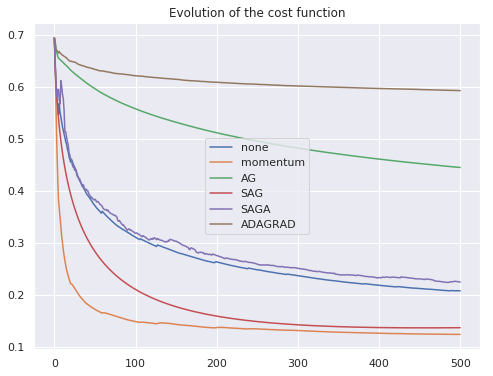

In [15]:
plt.figure(figsize=(8,6))

clf_none=LogisticRegression(alpha=alpha, bsize=bsize, iters=iters, gamma_lr=gamma_lr, acceleration="none")
clf_none.fit(X,y)

clf_momentum=LogisticRegression(alpha=alpha, bsize=bsize, theta=theta, iters=iters, acceleration="momentum")
clf_momentum.fit(X,y)

clf_AG=LogisticRegression(alpha=alpha, bsize=bsize, gamma_lr=gamma_lr, iters=iters, acceleration="AG")
clf_AG.fit(X,y)

clf_SAG=LogisticRegression(alpha=alpha, bsize=bsize, iters=iters, gamma_lr=gamma_lr, acceleration="SAG")
clf_SAG.fit(X,y)

clf_SAGA=LogisticRegression(alpha=alpha, bsize=bsize, gamma_lr=gamma_lr, iters=iters, acceleration="SAGA")
clf_SAGA.fit(X,y)

clf_ADAGRAD=LogisticRegression(alpha=alpha, bsize=bsize, gamma_lr=gamma_lr, lr=lr, iters=iters, acceleration="ADAGRAD")
clf_ADAGRAD.fit(X,y)

## Evolution of the cost function with parameters optimized for each strategy

Acceleration chosen : none
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.1099

Acceleration chosen : momentum
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.124

Acceleration chosen : AG
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.2279

Acceleration chosen : SAG
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.1369

Acceleration chosen : SAGA
	 500 iterations for 49749 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.1246

Acceleration chosen : ADAGRAD
	 500 iterations for 195 batches
	 === Result ===
	 Final Loss : Loss(beta) = 0.0483



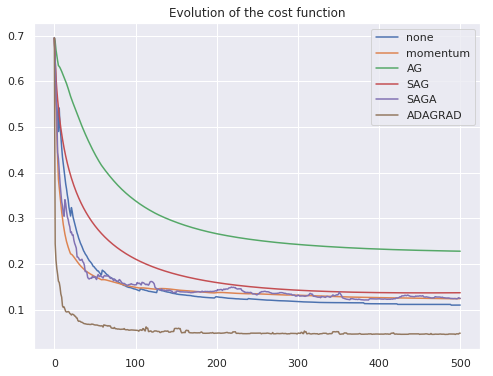

In [16]:
plt.figure(figsize=(8,6))

clf_none=LogisticRegression(alpha=alpha, bsize=bsize, iters=iters, gamma_lr=0, acceleration="none")
clf_none.fit(X,y)

clf_momentum=LogisticRegression(alpha=alpha, bsize=bsize, theta=theta, iters=iters, acceleration="momentum")
clf_momentum.fit(X,y)

clf_AG=LogisticRegression(alpha=alpha, bsize=bsize, gamma_lr=0, iters=iters, acceleration="AG")
clf_AG.fit(X,y)

clf_SAG=LogisticRegression(alpha=alpha, bsize=bsize, iters=iters, gamma_lr=gamma_lr, acceleration="SAG")
clf_SAG.fit(X,y)

clf_SAGA=LogisticRegression(alpha=alpha, bsize=bsize, gamma_lr=0, iters=iters, acceleration="SAGA")
clf_SAGA.fit(X,y)

clf_ADAGRAD=LogisticRegression(alpha=alpha, bsize=256, gamma_lr=0, lr=1, iters=iters, acceleration="ADAGRAD")
clf_ADAGRAD.fit(X,y)

## Predictions results for each optimized strategy

=== Acceleration chosen : none ===
Number of label 1 predictions : 0 - (0.0%)
Number of label -1 predictions : 14951 - (100.0%)
	 Accuracy : 0.9696341381847368 

=== Acceleration chosen : momentum ===
Number of label 1 predictions : 23 - (0.15%)
Number of label -1 predictions : 14928 - (99.85%)
	 Accuracy : 0.9692997123938198 

=== Acceleration chosen : AG ===
Number of label 1 predictions : 0 - (0.0%)
Number of label -1 predictions : 14951 - (100.0%)
	 Accuracy : 0.9696341381847368 

=== Acceleration chosen : SAG ===
Number of label 1 predictions : 0 - (0.0%)
Number of label -1 predictions : 14951 - (100.0%)
	 Accuracy : 0.9696341381847368 

=== Acceleration chosen : SAGA ===
Number of label 1 predictions : 17 - (0.11%)
Number of label -1 predictions : 14934 - (99.89%)
	 Accuracy : 0.9706374155574878 

=== Acceleration chosen : ADAGRAD ===
Number of label 1 predictions : 355 - (2.37%)
Number of label -1 predictions : 14596 - (97.63%)
	 Accuracy : 0.9856196909905692 



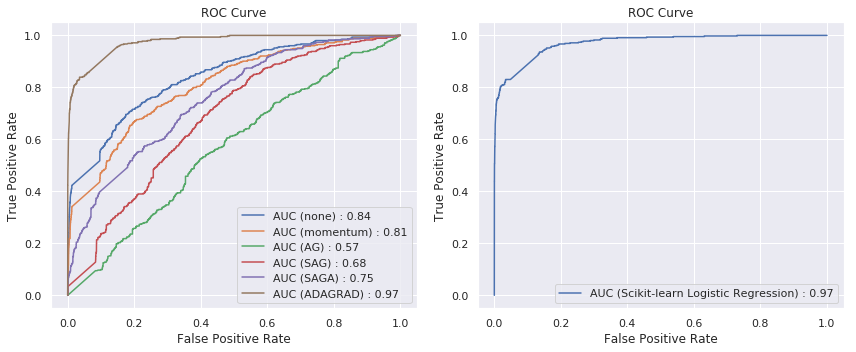

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(121)
""" Acceleration : None """
y_pred_labels=clf_none.predict(w8a_test_x.values)
y_pred_proba=clf_none.predict_proba(w8a_test_x.values)
show_results(y_pred_labels,y_test,clf_none.acceleration)
plot_roc(y_pred_proba,y_test,clf_none.acceleration)

""" Acceleration : Momentum """
y_pred_labels=clf_momentum.predict(w8a_test_x.values)
y_pred_proba=clf_momentum.predict_proba(w8a_test_x.values)
show_results(y_pred_labels,y_test,clf_momentum.acceleration)
plot_roc(y_pred_proba,y_test,clf_momentum.acceleration)

""" Acceleration : Gradient Averaging """
y_pred_labels=clf_AG.predict(w8a_test_x.values)
y_pred_proba=clf_AG.predict_proba(w8a_test_x.values)
show_results(y_pred_labels,y_test,clf_AG.acceleration)
plot_roc(y_pred_proba,y_test,clf_AG.acceleration)

""" Acceleration : SAG """
y_pred_labels=clf_SAG.predict(w8a_test_x.values)
y_pred_proba=clf_SAG.predict_proba(w8a_test_x.values)
show_results(y_pred_labels,y_test,clf_SAG.acceleration)
plot_roc(y_pred_proba,y_test,clf_SAG.acceleration)

""" Acceleration : SAGA """
y_pred_labels=clf_SAGA.predict(w8a_test_x.values)
y_pred_proba=clf_SAGA.predict_proba(w8a_test_x.values)
show_results(y_pred_labels,y_test,clf_SAGA.acceleration)
plot_roc(y_pred_proba,y_test,clf_SAGA.acceleration)

""" Acceleration : ADAGRAD """
y_pred_labels=clf_ADAGRAD.predict(w8a_test_x.values)
y_pred_proba=clf_ADAGRAD.predict_proba(w8a_test_x.values)
show_results(y_pred_labels,y_test,clf_ADAGRAD.acceleration)
plot_roc(y_pred_proba,y_test,clf_ADAGRAD.acceleration)

""" Scikit-learn Logistic Regression"""
plt.subplot(122)
plot_roc(y_pred_proba_SK,y_test,"Scikit-learn Logistic Regression")

plt.tight_layout()